In [ ]:
!pip install -q xgboost joblib scikit-learn pyarrow


In [ ]:
import numpy as np
import pandas as pd

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import joblib
import json

import warnings
warnings.filterwarnings("ignore")

print("Environment ready")


Environment ready


In [ ]:
DATA_PATH = "/content/canonical_checkpoint_features_with_soh_and_split.parquet"

df = pd.read_parquet(DATA_PATH)
print(df.shape)
df.head()


(118770, 27)


,asset_id,cycle_id,V_mean,V_std,V_min,V_max,V_range,dV_dt_mean,dV_dt_max,T_mean,...,T_delta_base,duration_base,use_dV_dt,V_range_norm,T_delta_norm,duration_norm,dV_dt_norm,Degradation_Index,SOH_proxy,split
0,0,0,3.735076,0.245422,2.699819,4.191235,1.491416,-35.948592,38.111247,40.419340,...,1.335614,0.038896,True,0.692878,0.669490,0.729033,0.741807,0.708302,0.492480,train
1,0,1,3.735681,0.244972,2.699859,4.192679,1.492819,-36.342517,34.652440,40.327115,...,1.335614,0.038896,True,0.693348,0.688454,0.722873,0.693107,0.699446,0.496861,train
2,0,10,3.739525,0.240002,2.699924,4.192582,1.492658,-38.022390,41.584546,40.363359,...,1.335614,0.038896,True,0.693295,0.693133,0.699661,0.788435,0.718631,0.487419,train
3,0,11,3.739852,0.239651,2.699803,4.192502,1.492699,-38.328526,34.646588,40.433203,...,1.335614,0.038896,True,0.693308,0.711655,0.697407,0.693023,0.698848,0.497158,train
4,0,12,3.740231,0.238893,2.699924,4.192462,1.492538,-38.309224,34.655228,40.393250,...,1.335614,0.038896,True,0.693254,0.702437,0.695238,0.693147,0.696019,0.498566,train


In [ ]:
expected_features = [
    "V_mean","V_std","V_min","V_max","V_range",
    "dV_dt_mean","dV_dt_max",
    "T_mean","T_max","T_delta",
    "duration_s"
]

required_cols = expected_features + ["SOH_proxy", "asset_id", "cycle_id"]

missing = set(required_cols) - set(df.columns)
print("Missing columns:", missing)


Missing columns: set()


In [ ]:
SOH_THRESHOLD = 0.85

t_delta_75 = df["T_delta"].quantile(0.75)

healthy_df = df[
    (df["SOH_proxy"] >= SOH_THRESHOLD) &
    (df["T_delta"] <= t_delta_75)
].copy()

print("Healthy cycles:", healthy_df.shape[0])
print("Total cycles:", df.shape[0])


Healthy cycles: 29117
Total cycles: 118770


In [ ]:
X_healthy = healthy_df[expected_features]


In [ ]:
iso_forest = IsolationForest(
    n_estimators=300,
    contamination="auto",
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(X_healthy)

print("Isolation Forest trained")


Isolation Forest trained


In [ ]:
df["if_score"] = iso_forest.score_samples(df[expected_features])


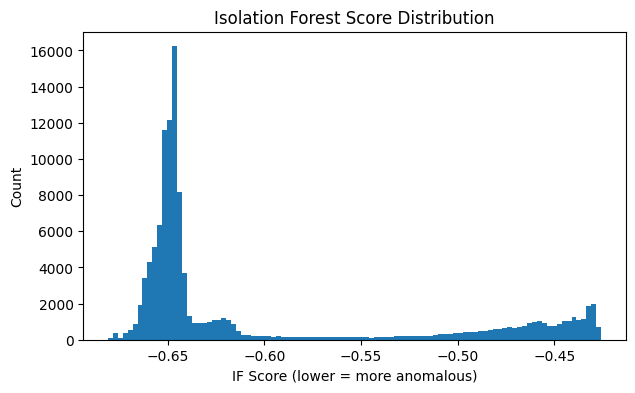

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(df["if_score"], bins=100)
plt.title("Isolation Forest Score Distribution")
plt.xlabel("IF Score (lower = more anomalous)")
plt.ylabel("Count")
plt.show()


KeyError: 'if_score'

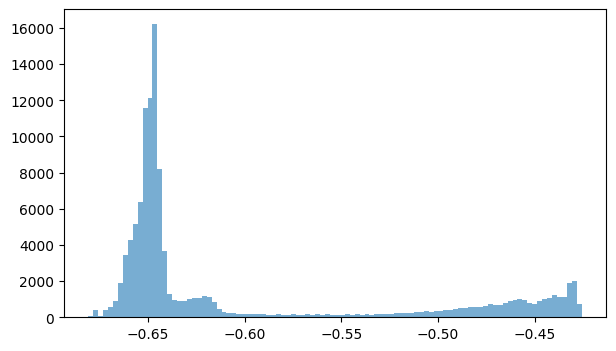

In [ ]:
plt.figure(figsize=(7,4))
plt.hist(df["if_score"], bins=100, alpha=0.6, label="All cycles")
plt.hist(
    healthy_df["if_score"],
    bins=100,
    alpha=0.6,
    label="Healthy cycles"
)
plt.legend()
plt.title("IF Score: Healthy vs All")
plt.show()


In [ ]:
stress_cols = ["V_range", "T_delta", "duration_s"]

df[stress_cols + ["if_score"]].corr()["if_score"]


,if_score
V_range,-0.535722
T_delta,-0.258774
duration_s,-0.026118
if_score,1.000000


In [ ]:
df.sort_values("if_score").head(10)[
    ["asset_id","cycle_id","if_score","SOH_proxy","V_range","T_delta","duration_s"]
]


,asset_id,cycle_id,if_score,SOH_proxy,V_range,T_delta,duration_s
111633,4,45,-0.680887,0.543372,1.431510,1.695697,0.025705
111603,4,18,-0.679544,0.489618,1.491036,1.770489,0.037559
111617,4,30,-0.679544,0.482769,1.489514,1.882728,0.035872
111665,5,32,-0.679544,0.499874,1.487799,1.710422,0.035064
111624,4,37,-0.679544,0.492968,1.489754,1.795422,0.034940
111625,4,38,-0.679544,0.478500,1.488433,1.907661,0.034767
111667,5,34,-0.679544,0.489153,1.489604,2.010040,0.034915
111613,4,27,-0.679544,0.480063,1.490275,1.795421,0.036236
111623,4,36,-0.679544,0.494190,1.490195,1.758022,0.035063
111629,4,41,-0.679544,0.513582,1.489033,1.770489,0.034512


In [ ]:
healthy_scores = healthy_df["if_score"]

p1 = np.percentile(healthy_scores, 1)
p5 = np.percentile(healthy_scores, 5)

print("Healthy 1%:", p1)
print("Healthy 5%:", p5)


KeyError: 'if_score'

In [ ]:
df["if_score"] = iso_forest.score_samples(df[expected_features])

healthy_df = df[
    (df["SOH_proxy"] >= SOH_THRESHOLD) &
    (df["T_delta"] <= t_delta_75)
].copy()


In [ ]:
print(df["if_score"].describe())
print(healthy_df["if_score"].describe())


count    118770.000000
mean         -0.602014
std           0.079819
min          -0.680887
25%          -0.651446
50%          -0.645885
75%          -0.572390
max          -0.425793
Name: if_score, dtype: float64
count    29117.000000
mean        -0.467447
std          0.034628
min         -0.644818
25%         -0.486041
50%         -0.459103
75%         -0.439572
max         -0.425793
Name: if_score, dtype: float64


In [ ]:
joblib.dump(iso_forest, "isolation_forest_anomaly.pkl")


['isolation_forest_anomaly.pkl']

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]


In [ ]:
WINDOW = 20

sequences = []

for asset_id, g in healthy_df.groupby("asset_id"):
    g = g.sort_values("cycle_id")
    X = g[expected_features].values

    for i in range(len(X) - WINDOW):
        sequences.append(X[i:i+WINDOW])

sequences = np.array(sequences)
print("Total healthy sequences:", sequences.shape)


Total healthy sequences: (29089, 20, 11)


In [ ]:
scaler = RobustScaler()

flat = sequences.reshape(-1, sequences.shape[-1])
flat_scaled = scaler.fit_transform(flat)

sequences_scaled = flat_scaled.reshape(sequences.shape)

print("sequences_scaled shape:", sequences_scaled.shape)


sequences_scaled shape: (29089, 20, 11)


In [ ]:
print("NaN ratio:",
      np.isnan(sequences_scaled).sum() / sequences_scaled.size)

print("Sequences ready for LSTM AE (NaNs allowed)")


NaN ratio: 0.14702839873866722
Sequences ready for LSTM AE (NaNs allowed)


In [ ]:
# Replace NaNs AFTER scaling (important)
sequences_scaled = np.nan_to_num(sequences_scaled, nan=0.0)

print("NaNs after fix:", np.isnan(sequences_scaled).any())


NaNs after fix: False


In [ ]:
train_seq, val_seq = train_test_split(
    sequences_scaled,
    test_size=0.15,
    random_state=42
)


In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]


train_ds = SequenceDataset(train_seq)
val_ds   = SequenceDataset(val_seq)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 387
Val batches: 69


In [ ]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super().__init__()

        self.encoder = nn.LSTM(
            input_dim, hidden_dim, batch_first=True
        )

        self.latent = nn.Linear(hidden_dim, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, hidden_dim)

        self.decoder = nn.LSTM(
            hidden_dim, input_dim, batch_first=True
        )

    def forward(self, x):
        _, (h, _) = self.encoder(x)
        z = self.latent(h[-1])

        dec_input = self.decoder_input(z).unsqueeze(1)
        dec_input = dec_input.repeat(1, x.size(1), 1)

        x_hat, _ = self.decoder(dec_input)
        return x_hat


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMAutoencoder(
    input_dim=train_seq.shape[-1]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

print("Model running on:", device)


Model running on: cpu


In [ ]:
EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        recon = model(batch)
        loss = criterion(recon, batch)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            recon = model(batch)
            loss = criterion(recon, batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    if epoch % 5 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch:02d} | Train {train_loss:.6f} | Val {val_loss:.6f}")


Epoch 00 | Train 19.211313 | Val 19.901058
Epoch 05 | Train 19.140419 | Val 19.893693
Epoch 10 | Train 19.136812 | Val 19.880800
Epoch 15 | Train 19.133447 | Val 19.863852
Epoch 20 | Train 19.112199 | Val 19.853784
Epoch 25 | Train 19.094767 | Val 19.848510
Epoch 29 | Train 19.090498 | Val 19.844990


In [ ]:
model.eval()

recon_errors = []

with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        recon = model(batch)

        # mean squared error per sequence
        error = torch.mean((recon - batch) ** 2, dim=(1, 2))
        recon_errors.extend(error.cpu().numpy())

recon_errors = np.array(recon_errors)

print("Reconstruction errors shape:", recon_errors.shape)


Reconstruction errors shape: (4364,)


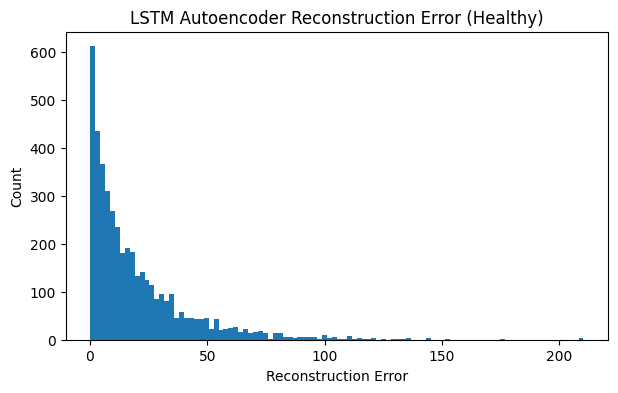

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(recon_errors, bins=100)
plt.title("LSTM Autoencoder Reconstruction Error (Healthy)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.show()


In [ ]:
ae_p95 = np.percentile(recon_errors, 95)
ae_p99 = np.percentile(recon_errors, 99)

print("AE 95% threshold (WATCH):", ae_p95)
print("AE 99% threshold (UNSAFE):", ae_p99)


AE 95% threshold (WATCH): 63.938198
AE 99% threshold (UNSAFE): 102.21337


In [ ]:
df_sorted = df.sort_values(["asset_id", "cycle_id"]).reset_index(drop=True)

all_sequences = []
seq_index = []  # track where each sequence ends

for asset_id, g in df_sorted.groupby("asset_id"):
    g = g.sort_values("cycle_id")
    X = g[expected_features].values

    for i in range(len(X) - WINDOW):
        all_sequences.append(X[i:i+WINDOW])
        seq_index.append((asset_id, g.iloc[i+WINDOW]["cycle_id"]))

all_sequences = np.array(all_sequences)


In [ ]:
flat = all_sequences.reshape(-1, all_sequences.shape[-1])
flat_scaled = scaler.transform(flat)

all_sequences_scaled = flat_scaled.reshape(all_sequences.shape)
all_sequences_scaled = np.nan_to_num(all_sequences_scaled, nan=0.0)


In [ ]:
all_errors = []

model.eval()
with torch.no_grad():
    for i in range(0, len(all_sequences_scaled), 256):
        batch = torch.tensor(
            all_sequences_scaled[i:i+256],
            dtype=torch.float32
        ).to(device)

        recon = model(batch)
        error = torch.mean((recon - batch) ** 2, dim=(1,2))
        all_errors.extend(error.cpu().numpy())

all_errors = np.array(all_errors)


In [ ]:
ae_df = pd.DataFrame(
    seq_index,
    columns=["asset_id", "cycle_id"]
)

ae_df["ae_error"] = all_errors


In [ ]:
torch.save(model.state_dict(), "anomaly_lstm_autoencoder.pt")
joblib.dump(scaler, "anomaly_ae_scaler.joblib")

thresholds = {
    "ae_p95": float(ae_p95),
    "ae_p99": float(ae_p99)
}

with open("ae_thresholds.json", "w") as f:
    json.dump(thresholds, f, indent=2)

print("LSTM AE artifacts saved")


LSTM AE artifacts saved


In [ ]:
def normalize_ae_error(ae_error, p95):
    """
    AE normalized score:
    <1   : normal
    >=1  : anomalous
    """
    return ae_error / p95



In [ ]:
def normalize_if_score(if_score, if_p5):
    """
    Convert IF score to risk score
    """
    return max(0.0, (if_p5 - if_score) / abs(if_p5))


In [ ]:
def fuse_anomaly_scores(ae_norm, if_norm):
    return max(ae_norm, if_norm)


In [ ]:
def anomaly_zone(score):
    if score < 1.0:
        return "NORMAL"
    elif score < 1.5:
        return "WATCH"
    else:
        return "UNSAFE"
